In [20]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn

import nibabel as nib
import os
import time
import gc
import copy
import cv2
from sklearn.model_selection import train_test_split
import wandb
from torch.optim.lr_scheduler import CyclicLR
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_toolbelt import losses as L
wandb.login()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [21]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
#train_mask1,train_mask2,train_mask3,train_mask_all
class train_dl(torch.utils.data.Dataset):
    def __init__(self, frame):
        self.frame =frame
        self.image_files = [f for f in frame['train_images'].tolist()]
        self.mask_files1 = [f for f in frame['train_mask1'].tolist()]
        self.mask_files2 = [f for f in frame['train_mask2'].tolist()]
        self.mask_files3 = [f for f in frame['train_mask3'].tolist()]


    def __getitem__(self, index):
        img,mask=img_trf_train(str(self.image_files[index]),str(self.mask_files1[index]),str(self.mask_files2[index]),str(self.mask_files3[index]))
        return img, mask

    def __len__(self):
        return len(self.frame)
        
class val_dl(torch.utils.data.Dataset):
    def __init__(self,frame):
        self.frame =frame
        self.image_files = [f for f in frame['train_images'].tolist()]
        self.mask_files1 = [f for f in frame['train_mask1'].tolist()]
        self.mask_files2 = [f for f in frame['train_mask2'].tolist()]
        self.mask_files3 = [f for f in frame['train_mask3'].tolist()]

    def __getitem__(self, index):
        img,mask=img_trf_val(str(self.image_files[index]),str(self.mask_files1[index]),str(self.mask_files2[index]),str(self.mask_files3[index]))
        return img, mask

    def __len__(self):
        return len(self.frame)


class test_dl(torch.utils.data.Dataset):
    def __init__(self,frame):
        self.frame =frame
        self.image_files = [f for f in frame['test_images'].tolist()]
        self.mask_files1 = [f for f in frame['test_mask1'].tolist()]
        self.mask_files2 = [f for f in frame['test_mask2'].tolist()]
        self.mask_files3 = [f for f in frame['test_mask3'].tolist()]

    def __getitem__(self, index):
        img,mask=img_trf_val(str(self.image_files[index]),str(self.mask_files1[index]),str(self.mask_files2[index]),str(self.mask_files3[index]))
        return img, mask

    def __len__(self):
        return len(self.frame)


In [23]:
def img_trf_train(img_path,mask_path1,mask_path2,mask_path3):

    img=cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    msk1=cv2.imread(str(mask_path1), cv2.IMREAD_GRAYSCALE)
    msk2=cv2.imread(str(mask_path2), cv2.IMREAD_GRAYSCALE)
    msk3=cv2.imread(str(mask_path3), cv2.IMREAD_GRAYSCALE)

    #edged = cv2.Canny(msk, 50, 200) #for edge
    #msk=(edged > 0).astype(int) #for edge
    max_side1=max(img.shape[0],img.shape[1])
    max_side2=max(msk1.shape[0],msk1.shape[1])
    max_side=max(max_side1,max_side2)
    aug = A.Compose([
        A.PadIfNeeded(min_height=max_side, min_width=max_side,border_mode=cv2.BORDER_CONSTANT,value=0,p=1),
        A.Affine(scale=(0.8,1.1), shear=(-20,20), rotate=(-20,20), p=0.8,fit_output=True,keep_ratio=True,mode=0,cval=0),
        #A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, p=0.1),
        #A.RandomBrightnessContrast(p=0.5),
        A.Resize(128,128),
    ],is_check_shapes=False)
    
    masks=np.stack([msk1,msk2,msk3],axis=0).T
    augmented = aug(image=img, mask=masks)
    
    image_padded = torch.tensor(augmented['image'].T)
    mask_padded = torch.tensor(augmented['mask'].T)
    return image_padded, mask_padded


def img_trf_val(img_path,mask_path1,mask_path2,mask_path3):

    img=cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    msk1=cv2.imread(str(mask_path1), cv2.IMREAD_GRAYSCALE)
    msk2=cv2.imread(str(mask_path2), cv2.IMREAD_GRAYSCALE)
    msk3=cv2.imread(str(mask_path3), cv2.IMREAD_GRAYSCALE)

    #edged = cv2.Canny(msk, 50, 200) #for edge
    #msk=(edged > 0).astype(int) #for edge
    max_side1=max(img.shape[0],img.shape[1])
    max_side2=max(msk1.shape[0],msk1.shape[1])
    max_side=max(max_side1,max_side2)
    aug = A.Compose([
        A.PadIfNeeded(min_height=max_side, min_width=max_side,border_mode=cv2.BORDER_CONSTANT,value=0,p=1),
        A.Resize(128,128),
    ],is_check_shapes=False)
    
    masks=np.stack([msk1,msk2,msk3],axis=0).T

    augmented = aug(image=img, mask=masks)
    
    image_padded = torch.tensor(augmented['image'].T)
    mask_padded = torch.tensor(augmented['mask'].T)
    return image_padded, mask_padded


In [24]:
train_data=pd.read_csv('train_data.csv')
test_data=pd.read_csv('test_data.csv')
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)
train_data.columns

Index(['train_images', 'train_mask1', 'train_mask2', 'train_mask3',
       'train_mask_all'],
      dtype='object')

In [25]:
train_dataset=train_dl(train_df)
val_dataset=val_dl(val_df)
train_dataloader = DataLoader(train_dataset, batch_size=256,pin_memory=True,shuffle=True,num_workers=2)
val_dataloader= DataLoader(val_dataset, batch_size=256,pin_memory=True,shuffle=False,num_workers=2)

#train_features,train_labels = next(iter(train_dataloader))

#train_set=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features,train_labels), batch_size=4,pin_memory=True,shuffle=True,num_workers=2)

    

In [26]:
test_dataset = test_dl(test_data)

test_dataloader=DataLoader(test_dataset, batch_size=64,pin_memory=True,shuffle=False,num_workers=2)
#test_features,test_labels = next(iter(test_dataloader))

#test_set=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features,train_labels), batch_size=4,pin_memory=True,shuffle=True,num_workers=2)


In [31]:


model = smp.Unet(
    encoder_name="resnet34",      
    encoder_weights="imagenet",     
    in_channels=1,                
    classes=3,                     

)

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
loss_function=L.DiceLoss(mode='multilabel',log_loss=False,from_logits=False)#binary vagy multiclass - log(dice_coeff)
lr=1e-3

optimizer=optim.Adam(model.parameters(), lr=lr, weight_decay=0.000001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.3, patience=3, verbose=True)
scheduler = CyclicLR(optimizer, 
                 base_lr = 0.00001, # Initial learning rate which is the lower boundary in the cycle for each parameter group
                 max_lr = 1e-3, # Upper learning rate boundaries in the cycle for each parameter group
                 step_size_up = 10, # Number of training iterations in the increasing half of a cycle
                 mode = "exp_range")
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [33]:
num_epochs =50

def train_model(model,loss_function,optimizer):
    wandb.init()
    model=model
    loss_function=loss_function
    optimizer=optimizer
    since=time.time()

    best_error=100
    #best_model=copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        running_loss=0
        for images, labels in train_dataloader:
            #print(images.shape)
            images=images.unsqueeze(1)
            labels=labels
            #print(labels.shape)
            images=images.to(device=device, dtype=torch.float) 
            labels=labels.to(device=device, dtype=torch.float) 
            outputs = model(images)
            #print(outputs.shape,'lable',labels.shape)
            optimizer.zero_grad()
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        validation_loss=0
        with torch.no_grad():
            for images,labels in test_dataloader:
                images=images.unsqueeze(1)
                labels=labels
                images=images.to(device=device, dtype=torch.float) 
                labels=labels.to(device=device, dtype=torch.float) 
                output_val=model(images)
                val_loss=loss_function(output_val,labels)
                validation_loss += val_loss.item()

        t_loss=running_loss/len(train_dataloader)
        v_loss=validation_loss/len(test_dataloader)
        
        scheduler.step()#v_loss)
        lrrate=optimizer.param_groups[0]["lr"]

        if v_loss<=best_error:
                best_error=v_loss
                best_epoch=epoch
                print(best_error,best_epoch)
                best_model=copy.deepcopy(model.state_dict())
                torch.save(best_model,'./Unet_Dice_plus_mask.pt')
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {t_loss},Validation Loss: {v_loss},Lr : {lrrate}")
        wandb.log({"train_loss": t_loss, "val_loss":v_loss,"lr":lrrate,"best_epoch":best_epoch,"epoch": epoch+1})           

        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()

    time_elapsed=time.time()-since
    print(f"Training time was:[{time_elapsed}]")


In [34]:

train_model(model,loss_function,optimizer)

best_epoch,▁▁▁▂▂▂▃▃▄▅▅▅▅▇▇▇▇███████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
lr,▃▄▆▅▂▃▄▄▃▂▇█▆▅▃▄▆▇▇▄▂▂▄▄▅▇█▇▃▂▄▆▃▂▂▇▆▁▂▆
train_loss,█▇▄▃▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,68
epoch,150
lr,0.001
train_loss,4.15198
val_loss,14.46402


0.103681640151669 0
Epoch [1/50], Training Loss: 0.18361633767684302,Validation Loss: 0.103681640151669,Lr : 0.00010900000000000009
-0.1686630187665715 1
Epoch [2/50], Training Loss: 0.028316745922590297,Validation Loss: -0.1686630187665715,Lr : 0.00020800000000000018
-0.3964119693812202 2
Epoch [3/50], Training Loss: -0.23612832153836885,Validation Loss: -0.3964119693812202,Lr : 0.00030699999999999987
-0.6703299985212439 3
Epoch [4/50], Training Loss: -0.4633067349592845,Validation Loss: -0.6703299985212439,Lr : 0.00040599999999999995
-0.8444003112175885 4
Epoch [5/50], Training Loss: -0.6363849341869354,Validation Loss: -0.8444003112175885,Lr : 0.000505
Epoch [6/50], Training Loss: -0.7539690136909485,Validation Loss: -0.8357079484883476,Lr : 0.0006040000000000002
-0.8799664728781756 6
Epoch [7/50], Training Loss: -0.815556138753891,Validation Loss: -0.8799664728781756,Lr : 0.0007030000000000002
-0.8841150718576768 7
Epoch [8/50], Training Loss: -0.8420092165470123,Validation Loss: -

In [11]:
from torch import rand, randint
from torchmetrics.classification import JaccardIndex
model.eval()
i=0
for images, labels in test_dataloader:
    images=images.unsqueeze(1)
    labels=labels
    images=images.to(device=device, dtype=torch.float) 
    labels=labels.to(device=device, dtype=torch.long) 
    outputs = model(images)

    #print(outputs)
    i=i+1
    if i>10:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


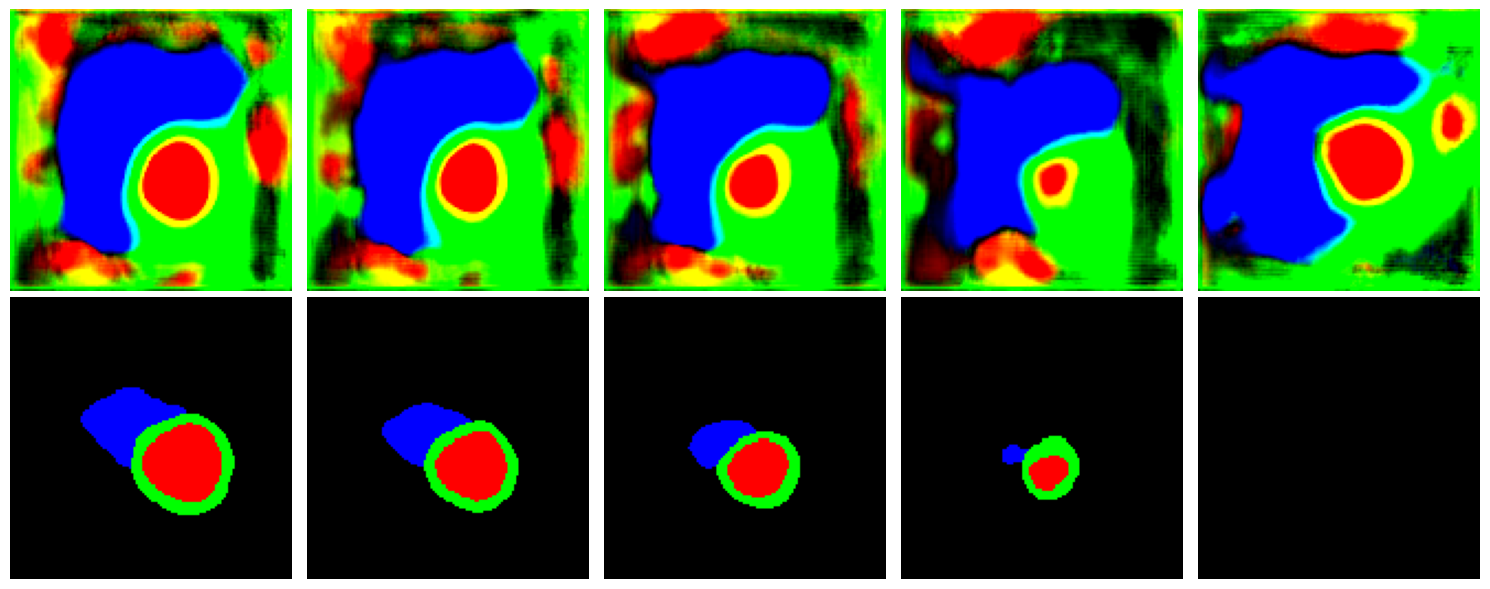

In [46]:
import matplotlib.pyplot as plt

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop over the images
for i in range(5):
    # Plot the output image on the first row (i-th image)
    axes[i].imshow(outputs.cpu().detach().numpy()[i, :, :, :].T,cmap='hot')
    axes[i].axis('off')  # Hide the axis for a cleaner view
    
    # Plot the corresponding label image on the second row (i-th image, shifted by 5)
    axes[i + 5].imshow(labels.cpu().detach().numpy()[i, :, :, :].T,cmap='hot')
    axes[i + 5].axis('off')  # Hide the axis for a cleaner view

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure to a file
plt.savefig('wrong_output.png', dpi=300)  # Save as PNG with high resolution

# Optionally, display the plot
plt.show()


In [13]:
labels.max()

tensor(255, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


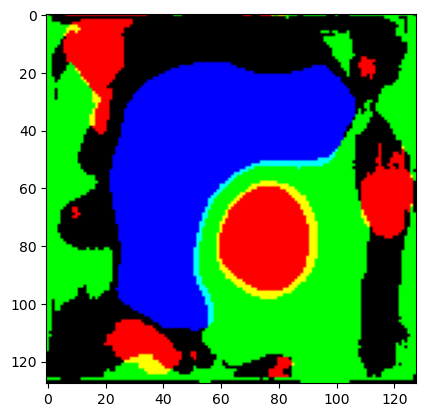

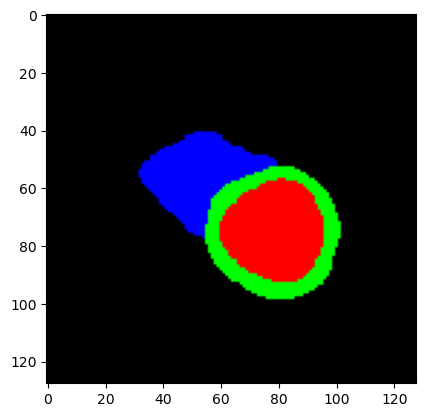

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


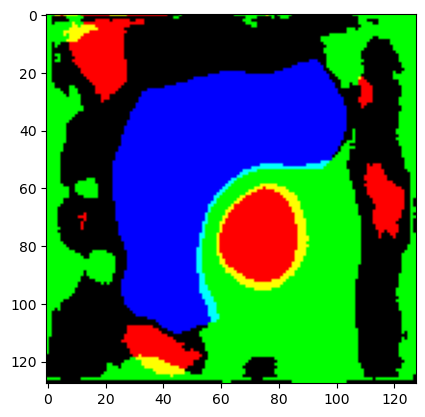

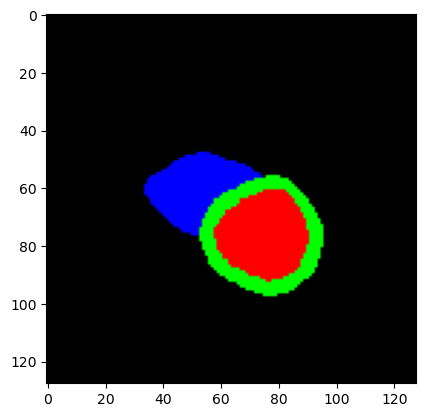

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


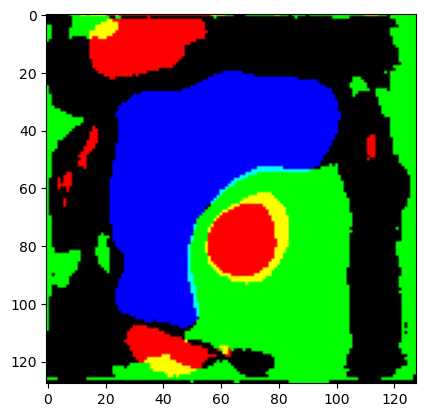

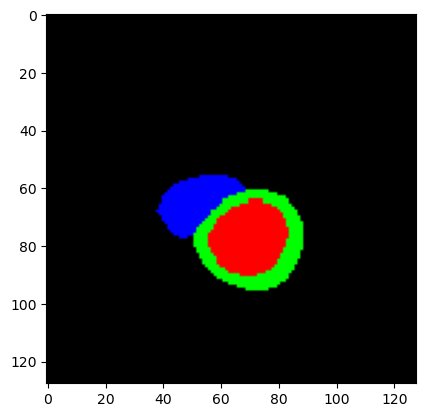

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


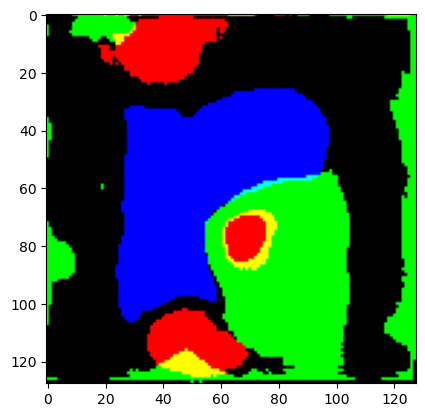

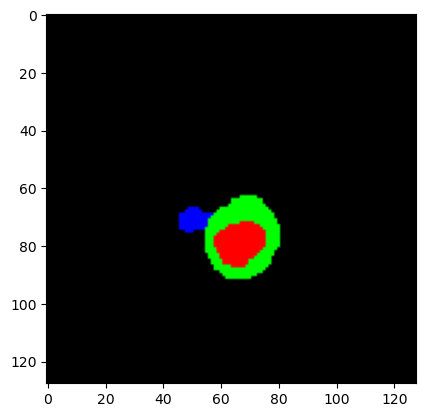

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


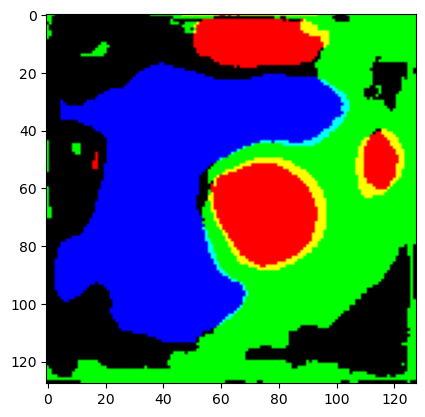

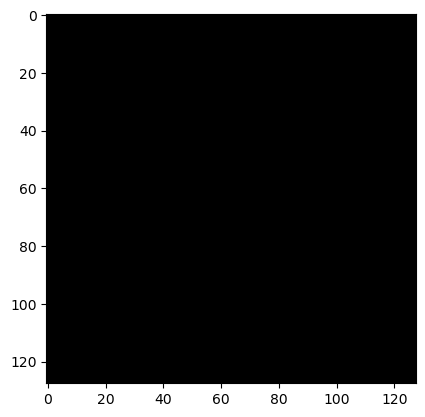

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


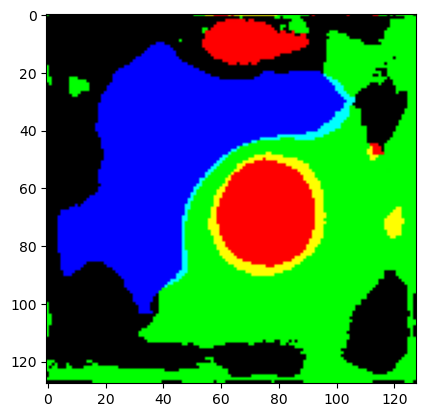

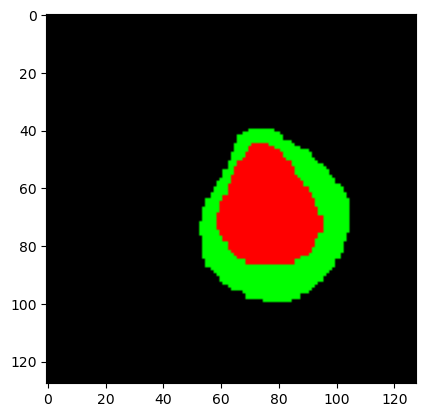

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


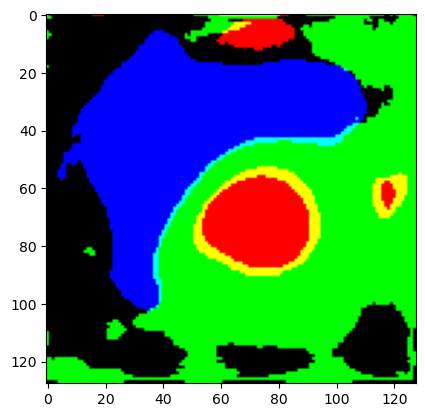

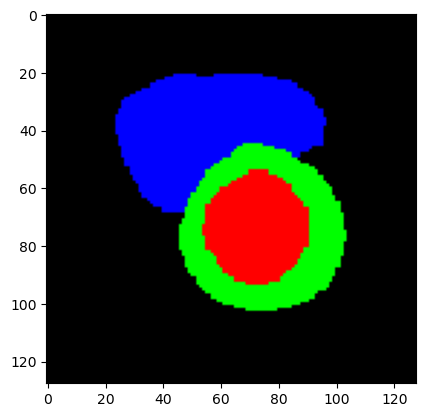

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


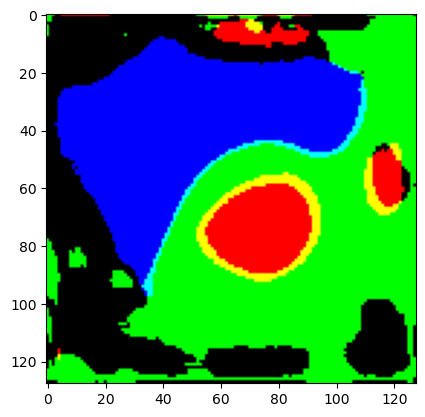

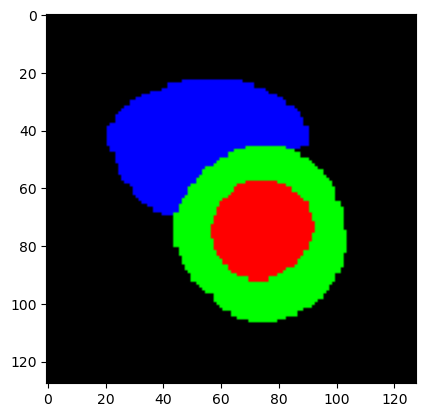

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


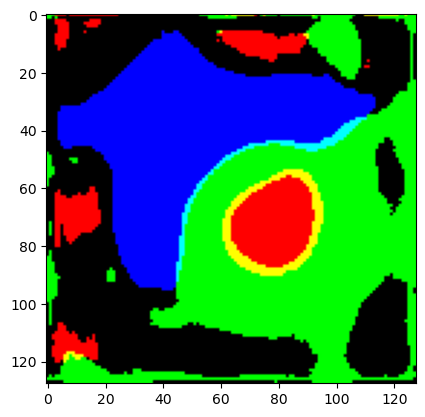

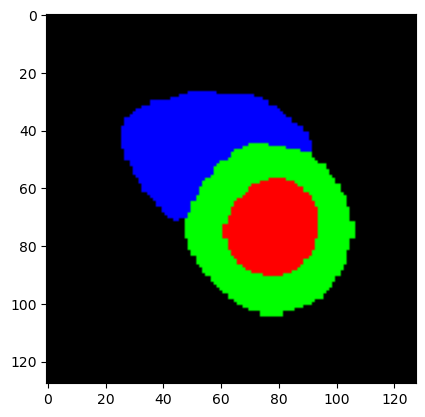

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


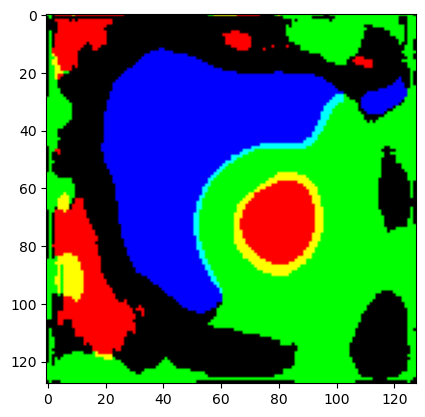

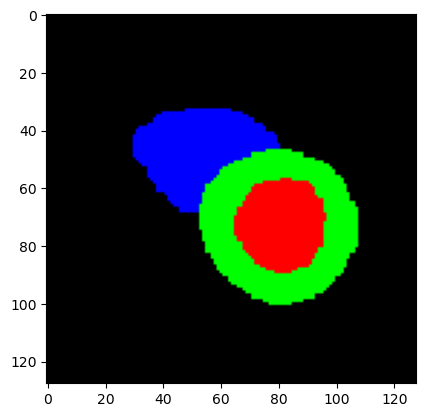

In [19]:
for i in range(10):
    # Process and plot outputs
    output_data = outputs.cpu().detach().numpy()[i, :, :, :].T
    output_masked = output_data * (output_data>=0.99)  # Retain values > 0.8
    plt.imshow(output_masked, cmap='hot')  # You can choose an appropriate colormap
    plt.show()

    # Process and plot labels
    label_data = labels.cpu().detach().numpy()[i, :, :, :].T
    label_masked = label_data * (label_data > 0.9)  # Retain values > 0.8
    plt.imshow(label_masked, cmap='hot')  # Use the same colormap for consistency
    plt.show()


In [15]:
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
